# Image Segmentation

## Overview

### Learning Objectives

* Gain familiarity with the different categories of segmentation methods available in ITK
* Understand the difference between region growing methods and how their parameters change their behavior
* Understand the influence of terms in level set segmentation methods

### Segmentation method categories

![Segmentation categories](data/segmentation-categories.png)

### Region Growing Methods

The basic approach of a *region growing algorithm* is to **start from a seed region (typically one or more
pixels)** that are considered to be inside the object to be segmented. The **pixels neighboring this
region are evaluated to determine if they should also be considered part of the object**. If so, **they are
added to the region and the process continues as long as new pixels are added to the region**. Region
growing algorithms vary depending on the criteria used to decide whether a pixel should be included
in the region or not, the type connectivity used to determine neighbors, and the strategy used to visit
neighboring pixels.

Example region growing methods available in ITK:

- ConfidenceConnected
- ConnectedThreshold
- IsolatedConnected

#### Confidence Connected

![Confidence Connected](data/confidence-connected.png)

#### Connected Threshold

![Connected Threshold](data/connected-threshold.png)

#### Isolated Connected

![Isolated Connected](data/isolated-connected.png)

### Level Set Segmentation Methods

### Level Set Concept

![Level set concept](data/level-set-concept.png)



#### Level Set Evolution

![Level Set evolution](data/level-set-evolution.png)

#### Level Set Function

$\phi_{t} = - \alpha  \mathbf{A}(\mathbf{x})\cdot\nabla\phi - \beta   P(\mathbf{x})\mid\nabla\phi\mid + \gamma Z(\mathbf{x})\kappa\mid\nabla\phi\mid$

- $\mathbf{A}(\mathbf{x})$: **Advection**
- $P(\mathbf{x})$: **Propagation**
- $Z(\mathbf{x})$: **Spatial modifier for the mean curvature $\kappa$**
- $\alpha, \beta, \gamma$ are scalar constants

- Track the evolution of contours and surfaces by computing the update to the solution $\phi$ of the PDE
- Contour (initial solution) is initialized by the user
- Evolve $\phi$ until
  - It fits the form of the segment you are trying to fit (shape detection)
  - It segments the features you want (segmentation)
- Evolution is uni-directional (inwards or outwards)

For more information, see:

- The [*Segmentation* chapter](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1770004) of Book 2 of the ITK Software Guide, including the sections on [*Region Growing*](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1780004.1) and [*Level Set Segmentation*](https://itk.org/ITKSoftwareGuide/html/Book2/ITKSoftwareGuide-Book2ch4.html#x37-1890004.3).

## Tutorial

In [45]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline

#### itk.ConfidenceConnectedImageFilter

From [itk::ConfidenceConnectedImageFilter documentation](https://itk.org/Doxygen/html/classitk_1_1ConfidenceConnectedImageFilter.html):

> Segment pixels with similar statistics using connectivity.

> This filter extracts a connected set of pixels whose pixel intensities are consistent with the pixel statistics of a seed point. The mean and variance across a neighborhood (8-connected, 26-connected, etc.) are calculated for a seed point. Then pixels connected to this seed point whose values are within the confidence interval for the seed point are grouped. The width of the confidence interval is controlled by the "Multiplier" variable (the confidence interval is the mean plus or minus the "Multiplier" times the standard deviation). If the intensity variations across a segment were gaussian, a "Multiplier" setting of 2.5 would define a confidence interval wide enough to capture 99% of samples in the segment.

> After this initial segmentation is calculated, the mean and variance are re-calculated. All the pixels in the previous segmentation are used to calculate the mean the standard deviation (as opposed to using the pixels in the neighborhood of the seed point). The segmentation is then recalculated using these refined estimates for the mean and variance of the pixel values. This process is repeated for the specified number of iterations. Setting the "NumberOfIterations" to zero stops the algorithm after the initial segmentation from the seed point.

In [55]:
# Also observe the help with the Python `help` function
input_image = itk.imread('data/BrainProtonDensitySlice.png', pixelType=itk.ctype('unsigned char'))
confidence_connected = itk.ConfidenceConnectedImageFilter.New(input_image)
help(confidence_connected)

Help on itkConfidenceConnectedImageFilterIUC2ISS2 in module itkConfidenceConnectedImageFilterPython object:

class itkConfidenceConnectedImageFilterIUC2ISS2(itkImageToImageFilterAPython.itkImageToImageFilterIUC2ISS2)
 |  Segment pixels with similar statistics using connectivity.
 |  
 |  This filter extracts a connected set of pixels whose pixel intensities
 |  are consistent with the pixel statistics of a seed point. The mean and
 |  variance across a neighborhood (8-connected, 26-connected, etc.) are
 |  calculated for a seed point. Then pixels connected to this seed point
 |  whose values are within the confidence interval for the seed point are
 |  grouped. The width of the confidence interval is controlled by the
 |  "Multiplier" variable (the confidence interval is the mean plus or
 |  minus the "Multiplier" times the standard deviation). If the
 |  intensity variations across a segment were gaussian, a "Multiplier"
 |  setting of 2.5 would define a confidence interval wide enoug

In [29]:
# Or, observe the help with IPython `?` operator
confidence_connected?

In [60]:
# Set confidence connected filter parameters
confidence_connected.SetMultiplier(2.3)
confidence_connected.SetNumberOfIterations(5)
confidence_connected.SetInitialNeighborhoodRadius(3)
confidence_connected.SetReplaceValue(255)

In [14]:
# What is the *Multiplier*?
confidence_connected.SetMultiplier?

In [31]:
# View the input image
view(input_image)

Viewer(image=<itkImagePython.itkImageUC2; proxy of <Swig Object of type 'itkImageUC2 *' at 0x7effb97a6de0> >)

In [66]:
# Set the seed points
Dimension = input_image.GetImageDimension()
IndexType = itk.Index[Dimension]
index = IndexType()

index[0] = 100
index[1] = 110

confidence_connected.SetSeed(index)

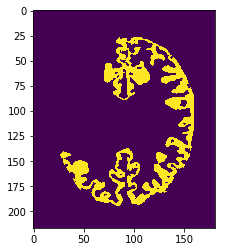

In [67]:
confidence_connected.Update()

plt.imshow(itk.GetArrayViewFromImage(confidence_connected.GetOutput()))

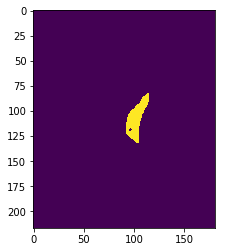

In [63]:
# Pre-process to improve the result
median = itk.MedianImageFilter.New(input_image)
median.SetRadius(1)

confidence_connected.SetInput(median)

confidence_connected.Update()
plt.imshow(itk.GetArrayViewFromImage(confidence_connected.GetOutput()))

In [33]:
fileName = 'data/PacMan.png'
reader = itk.ImageFileReader.New(FileName=fileName)

Next, let's create a smoothing filter. To connect the pipeline, specify the `Output` of the reader as the `Input` to the smoother.

In [ ]:
smoother = itk.RecursiveGaussianImageFilter.New(Input=reader.GetOutput())

#### Fast Marching Segmentation

When the differential equation governing the level set evolution has a very simple form, a fast evolution algorithm called fast marching can be used.

Front propagation: $\Delta x = V \Delta t$

![Fast marching speed image](data/fast-marching-speed-image.png)

#### Fast Marching Time Crossing

![Fast marching time crossing](data/fast-marching-time-crossing.png)

In [ ]:
smoother.Update()

print("reader's Output", reader.GetOutput())
print("smoother's Output", smoother.GetOutput())

Let's view the images.

In [ ]:
image = reader.GetOutput()
view(image)

In [ ]:
smoothed = smoother.GetOutput()
view(smoothed)

If we call `Update()` on the pipeline, the output pixel data is not needlessly generated because the pipeline is up-to-date.

In [ ]:
smoother.Update()

However, if we change the amount of smoothing, new pixel data does need to be generated from the output of the smoother.

In [ ]:
smoother.SetSigma(3.0)

In [ ]:
view(smoothed)

In [ ]:
smoother.Update()

Note, however, note that the reader does generate its output because it is up-to-date and upstream from the smoother.

If we artificially modify the reader, both the reader and the smoother need to regenerate their outputs.

In [ ]:
reader.Modified()

smoother.Update()

We can stream the pipeline by placing a [StreamingImageFilter](https://itk.org/Doxygen/html/classitk_1_1StreamingImageFilter.html) at the **end** of the pipeline. The smoother generates outputs multiple times, once for each image region streaming division. Since the reader is not capable of streaming, it only generates its output once.

In [ ]:
streamer = itk.StreamingImageFilter.New(Input=smoother.GetOutput())
streamer.SetNumberOfStreamDivisions(3)
reader.Modified()
streamer.Update()

## Exercises

### Exercise 1: The effect of Sigma

Change the value of Sigma on the smoothing filter.

- How is the output effected?
- What are the units of Sigma?

### Exercise 2: Does setting a filter parameter to its current value cause regeneration of its output?

Call `smoother.SetSigma(smoother.GetSigma())` then `smoother.Update()`. 

- Is the output regenerated? 
- Is this expected / desirable?

### Exercise 3: Find other image filtering algorithms

The classes in ITK are organized into **Modules**, and collections of Modules are organized into **Groups**. Examine the [Image Smoothing](https://itk.org/Insight/Doxygen/html/group__ITKSmoothing.html) Module and the [Filtering](https://itk.org/Insight/Doxygen/html/group__Group-Filtering.html) Group. Can any other smoothing or denoising classes be found? 

### Enjoy ITK!